# Extract

### Install libraries

In [1]:
!pip install emoji
!pip install -U kaleido

### Import libraries

In [2]:
import re
import emoji
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "png"

### Get File Name
After exporting your chat from whatsapp, copy the file's content and replace the dummy messages inside of messages.txt (found inside the project's folder) with the copied messages. You can CTRL + A, CTRL + C to easily copy all of the text inside the file.

The verify_file function verifies that the file has a txt extension and that it exists within the folder. This should always be the case if you use the above method to provide the chat messages, however, you could also alternatively move your exported chat messages into the project folder and replace "messages.txt" that's at the end of the bellow code block with the file name of your text file instead.

Whatever method you choose to use, the notebook requires that it has access to a text file containing the exported whatsapp messages.

In [3]:
def verify_file(name) -> None:
    """Makes sure the file name checks out"""

    # Make sure file extension is correct
    if not re.search(r"^.+\.txt$", name):
        print("❌ Invalid text file")
    else:
        # Make sure that the file exists
        try:
            with open(name) as file:
                print("✅ File accepted")
                return name
        except FileNotFoundError:
            print("❌ File does not exist")
            

text_file_name = verify_file("messages.txt")

✅ File accepted


### Convert Text file to DataFrame

This is where the text file is going to be parsed and converted into a pandas dataframe so it's easy to work with.

In [4]:
def text_to_df(file_name) -> pd.DataFrame:
    """Takes the whatsapp formatted file and extracts information from it
    Information is returned as a list of dictionaries containing keys: date,time,name,message
    """

    data = []
    with open(file_name, encoding='utf-8') as file:
        for row in file:
            # If normal whatsapp format, match will work and you'll get correct values
            try:
                match = re.search(
                    r"^(\d{1,2}/\d{1,2}/\d{2}),\s(\d{1,2}:\d{2})\s(AM|PM)\s-\s([^:]*):\s(.*)$",
                    row,
                )
                date, time, period, name, message = (
                    match.group(1),
                    match.group(2),
                    match.group(3),
                    match.group(4),
                    match.group(5),
                )
            # If match doesn't work, raised error will cause this code to work instead
            except:
                # If it's a whatsapp notification instead of a message, skip it
                if re.search(
                    r"^(\d{1,2}/\d{1,2}/\d{2}),\s(\d{1,2}:\d{2})\s(AM|PM)\s-\s", row
                ):
                    continue
                # If it's not, then it's probably a new line of a message, so add it to the last message
                data[len(data) - 1]["message"] += f" {row.rstrip()}"
                continue

            # If it's neither a notification nor part of previous message, then it's a normal message which you will append to the list of dicts
            data.append(
                {
                    "date": date,
                    "time": f"{time} {period}",
                    "name": name,
                    "message": message,
                }
            )
    return pd.DataFrame(data)

df = text_to_df(text_file_name) 

# Resulting DataFrame:
df.head(10)

,date,time,name,message
0,12/17/24,12:00 PM,Jim,Hi
1,12/18/24,12:00 PM,Jim,You deleted this message
2,12/18/24,12:00 PM,Jim,<Media omitted>
3,12/18/24,12:01 PM,Carlos,Hi 👀
4,12/18/24,12:03 PM,Jim,How are you? What have you been up to?
5,12/18/24,12:04 PM,Carlos,Nothing much Just vibing really <This message ...
6,12/18/24,12:10 PM,Jim,Boring
7,12/18/24,12:10 PM,Jim,<Media omitted>
8,12/18/24,12:12 PM,Carlos,I'm craving some coffee right now
9,12/18/24,12:13 PM,Jim,Go get some then


# Transform

### Fix column data types

In [5]:
# Fix data types for date and name columns
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')
df['time'] = pd.to_datetime(df['time'], format='%I:%M %p').dt.strftime('%H:%M')
df['name'] = df['name'].astype('category')

### Optional Name Manipulation

If you want to chage how the name of a person looks like in the analyzed data, you can uncomment (remove the #) the code bellow to do so.

This can also be used in cases where a person changed their number in a group chat and you want to change their previous name to be the same as the current name so the chats aren't counted as coming from two different people.

To change the name, replace the text inside the quotes "New Name" with the new name you wish to give the sender, and replace the text inside the quotes "Current Name" with the name found in the whatsapp exported chat file.

If you wish to change multiple names, just copy the code and paste it on a new line and do the same. You can do so as many times as you want.

In [6]:
#df['name'] = df['name'].apply(lambda x: "New Name" if x == "Current Name" else x)

### Feature Engineering

Here, we're creating new columns that represent different features of the message column, like is the message deleted, is it edited, how long is it, how many emojis does it contain, and is it an ommited voice recording/photo/video/sticker/gif.

This will allow for us to derive insights and create visuals.

Down in the code, you can also see "positive_patterns" and "negative_patterns" variables. There store a list of regex patterns that will be used to find messages that contain positive or negative mentions like "I like","I really enjoy","I actually adore", "I really hate", "I'm actually annoyed by", etc. These patterns are compiled toghether and used to create dataframes containing only those positive/netagive mentions in their messages.
This allows you to easily find information about a sender's likes/dislikes that they mentioned to you in the chat.

If you want to add to the patterns or completely replace them to filter for other things, you can do so if you know how to write regex, or you could ask some AI to help you write it.

In [7]:
# Make columns that:
# Show if message was edited
def is_edited(text: str) -> bool:
    text = text.strip()
    if text.endswith("<You edited this message>") or text.endswith("<This message was edited>"):
        return True
    else:
        return False
df['edited'] = df['message'].apply(lambda x: is_edited(x))
# Remove <This message was edited>
df['message'] = df['message'].apply(lambda x: x.replace("<This message was edited>", ""))

# Show if message is media
def is_media(text: str) -> bool:
    return True if re.match("<Media omitted>", text.strip()) else False
df['media'] = df['message'].apply(lambda x: "<Media omitted>" in x)

# Show if message is deleted
def is_deleted(text: str) -> bool:
    text = text.strip()
    return True if re.match("This message was deleted", text) or re.match("You deleted this message", text) else False
df['deleted'] = df['message'].apply(lambda x: "This message was deleted" in x or "You deleted this message" in x)

# Show if the message contains a positive mention
# First we're defining what we mean by "positive messages" in a list
positive_patterns = [
    r"\bi (?:like|love|adore|crave|enjoy|appreciate)\b",
    r"\bi(?:'m| am)? craving\b",
    r"\bi actually (?:like|love|adore|enjoy|appreciate)\b",
    r"\bi(?:'m| am)? actually craving\b",
    r"\bi really (?:like|love|adore|crave|enjoy|appreciate)\b",
    r"\bwe (?:like|love|adore|crave|enjoy|appreciate)\b",
    r"\bwe(?:'re| are)? craving\b",
    r"\bwe actually (?:like|love|adore|enjoy|appreciate)\b",
    r"\bwe(?:'re| are)? actually craving\b",
    r"\bwe really (?:like|love|adore|crave|enjoy|appreciate)\b",
]
# Here, we combine the patterns into 1 big regex expression with OR in between them and make a regex object out of it
positive_regex = re.compile("|".join(positive_patterns), re.IGNORECASE)
# Add the column 
df['positive_mentions'] = df['message'].apply(lambda x: bool(positive_regex.search(x.casefold())))

# Show if the message contains a negative mention
# Same code logic as the positive approach
negative_patterns = [
    r"\bi (hate|dislike|abhore|despise|get annoyed by|find it annoying)\b",
    r"\bi actually (hate|dislike|abhore|despise|get annoyed by|find it annoying)\b",
    r"\bi really (hate|dislike|abhore|despise|get annoyed by|find it annoying)\b",
    r"\bwe (hate|dislike|abhore|despise|get annoyed by|find it annoying)\b",
    r"\bwe actually (hate|dislike|abhore|despise|get annoyed by|find it annoying)\b",
    r"\bwe really (hate|dislike|abhore|despise|get annoyed by|find it annoying)\b",
    r"\bi don't (?:like|love|crave|enjoy|appreciate)\b",
    r"\bi don't really (?:like|love|crave|enjoy|appreciate)\b",
    r"\bwe don't (?:like|love|crave|enjoy|appreciate)\b",
    r"\bwe don't really (?:like|love|crave|enjoy|appreciate)\b",
    r"\bi really don't (?:like|love|crave|enjoy|appreciate)\b",
    r"\bwe really don't (?:like|love|crave|enjoy|appreciate)\b",
    r"\bi actually don't (?:like|love|crave|enjoy|appreciate)\b",
    r"\bwe actually don't (?:like|love|crave|enjoy|appreciate)\b",
]
negative_regex = re.compile("|".join(negative_patterns), re.IGNORECASE)
df['negative_mentions'] = df['message'].apply(lambda x: bool(negative_regex.search(x.casefold())))
# Potential things to work on in the future:
# Maybe make the filtering "fuzzy" so it's not as set in stone
# Maybe add questions too like "DO YOU like/hate/whatever"

# Show how many emojis are in the message
def count_emojis(text: str) -> int:
    if is_media(text) or is_deleted(text):
        return -1
    return sum(1 for char in text if char in emoji.EMOJI_DATA)    
df['emoji_count'] = df['message'].apply(count_emojis)

# Show how long the messages are
df['char_count'] = df['message'].apply(lambda x: -1 if is_media(x) or is_deleted(x) else len(x))

### Create Measures

In this section, we are grouping data from the dataframe by the "name" column, and calculating things like how many characters/messages/emojis/media each individual has sent, or how many messages each person deleted/edited. This will allow us to create visuals comparing different people according to those different aspects.

You can change "observed=True" if you want to only include names where you actually find values, so say if someone hasn't sent any messages, they wouldn't be included and therefore not shown later. With it set to "False" however, even if someone hasn't sent anything, they will still be included.

We're also grouping by date/time to count the messages in each date/time so we can later create visuals showing the relation between messages sent with date/time.

In [8]:
# Count how many medias each person has sent
media_count = df.groupby('name', observed=False)['media'].sum()

# Count how many messages each person has deleted
deleted_count = df.groupby('name', observed=False)['deleted'].sum()

# Count how many characters each person sent
chars_count = df[df['char_count'] > 0].groupby('name', observed=False)['char_count'].sum()

# Figure out who sends more emojis
emoji_count = df[df['emoji_count'] > 0].groupby('name', observed=False)['emoji_count'].sum()

# Figure out who has longer messages on average
avg_message_length = df[df['char_count'] > 0].groupby('name', observed=False)['char_count'].mean()

# Count how many messages each person has edited
edited_count = df.groupby('name', observed=False)['edited'].sum()

# Count how many messages were sent per day across a range of dates.
# Group data by date and count messages
date_message_counts = df.groupby('date').size().reset_index(name='message_count')
# Create range for the date to ensure all dates are present rather than just the ones present in the chat
date_range = pd.date_range(df['date'].min(), df['date'].max())
# Reindex the message_counts DataFrame
date_message_counts = date_message_counts.set_index('date').reindex(date_range, fill_value=0).reset_index()
date_message_counts.columns = ['date', 'message_count']

# Figure out what times of the day the chat is most active in.
# Group data by time and count messages
time_message_counts = df.groupby('time').size().reset_index(name='message_count')
# Create a full range of times (hour:minute) at 1-minute intervals
time_range = pd.date_range("00:00", "23:59", freq="1min").strftime('%H:%M')
# Create a DataFrame for the full range of times rather than just the ones present in the chat
time_range_df = pd.DataFrame({'time': time_range})
# Merge the full time range with the message counts to ensure all times are present
time_message_counts = time_range_df.merge(time_message_counts, on='time', how='left')
# Fill missing message counts with 0
time_message_counts['message_count'] = time_message_counts['message_count'].fillna(0).astype(int)

# Load

### Assert DataFrame as Clean

At this point, we're done making changes to the dataframe, and we're done extracting measures and sub-data frames.

In [9]:
df_clean = df

In [10]:
df_clean.head(10)

,date,time,name,message,edited,media,deleted,positive_mentions,negative_mentions,emoji_count,char_count
0,2024-12-17,12:00,Jim,Hi,False,False,False,False,False,0,2
1,2024-12-18,12:00,Jim,You deleted this message,False,False,True,False,False,-1,-1
2,2024-12-18,12:00,Jim,<Media omitted>,False,True,False,False,False,-1,-1
3,2024-12-18,12:01,Carlos,Hi 👀,False,False,False,False,False,1,4
4,2024-12-18,12:03,Jim,How are you? What have you been up to?,False,False,False,False,False,0,38
5,2024-12-18,12:04,Carlos,Nothing much Just vibing really,True,False,False,False,False,0,32
6,2024-12-18,12:10,Jim,Boring,False,False,False,False,False,0,6
7,2024-12-18,12:10,Jim,<Media omitted>,False,True,False,False,False,-1,-1
8,2024-12-18,12:12,Carlos,I'm craving some coffee right now,False,False,False,True,False,0,33
9,2024-12-18,12:13,Jim,Go get some then,False,False,False,False,False,0,16


In [11]:
df_clean.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               22 non-null     datetime64[ns]
 1   time               22 non-null     object        
 2   name               22 non-null     category      
 3   message            22 non-null     object        
 4   edited             22 non-null     bool          
 5   media              22 non-null     bool          
 6   deleted            22 non-null     bool          
 7   positive_mentions  22 non-null     bool          
 8   negative_mentions  22 non-null     bool          
 9   emoji_count        22 non-null     int64         
 10  char_count         22 non-null     int64         
dtypes: bool(5), category(1), datetime64[ns](1), int64(2), object(2)
memory usage: 1.2+ KB


# Analyze and Visualize

### Create Visuals

We can now start using the data we've prepared to create visuals that represent aspects of data we wish to analyze.

In [12]:
# Filter the DataFrame to show only messages with positive mentions
positive_messages_df = df_clean[df_clean['positive_mentions']][['name', 'date', 'time', 'message']]

# Filter the DataFrame to show only messages with negative mentions
negative_messages_df = df_clean[df_clean['negative_mentions']][['name', 'date', 'time', 'message']]

# Show message frequency over time
date_message_fig = px.line(
    date_message_counts,
    x='date',  # x-axis is the date
    y='message_count',  # y-axis is the count of messages
    title='Messaging Rate Over Time',
    labels={'date': '', 'message_count': ''}
)

# Create a bar plot of message counts over time
top_msg_hours_fig = px.bar(
    time_message_counts, 
    x='time', 
    y='message_count', 
    title='Chat Activity',
    labels={'time': 'Time of Day', 'message_count': ''}
)

# Show who sent more messages
msg_sent_fig = px.histogram(
    df_clean, 
    x='name', 
    color='name', 
    title="Who sends more messages?",
    labels={"name": ""}  
)
msg_sent_fig.update_layout(yaxis_title="")
msg_sent_fig.update_layout(showlegend=False)

# Show who sent more letters
chars_count_df = chars_count.reset_index()
chars_count_df.columns = ['name', 'char_count']
char_count_fig = px.bar(
    chars_count_df,
    x='name',
    y='char_count',
    color='name',
    title='Who sent more characters?',
    labels={'name': '', 'char_count': ''}
)
char_count_fig.update_layout(showlegend=False)

# Show who deletes more messages
deleted_count_df = deleted_count.reset_index()
deleted_count_df.columns = ['name', 'deleted_count']
deleted_count_fig = px.bar(
    deleted_count_df,
    x='name',
    y='deleted_count',
    color='name',
    title='Who deleted more messages?',
    labels={'name': '', 'deleted_count': ''}
)
deleted_count_fig.update_layout(showlegend=False)

# Show who edits more messages
edited_count_df = edited_count.reset_index()
edited_count_df.columns = ['name', 'edited_count']
edited_count_fig = px.bar(
    edited_count_df,
    x='name',
    y='edited_count',
    color='name',
    title='Who edited more messages?',
    labels={'name': '', 'edited_count': ''}
)
edited_count_fig.update_layout(showlegend=False)

# Show who sends more media
media_count_df = media_count.reset_index()
media_count_df.columns = ['name', 'media_count']
media_count_fig = px.bar(
    media_count_df,
    x='name',
    y='media_count',
    color='name',
    title='Who sent more media?',
    labels={'name': '', 'media_count': ''}
)
media_count_fig.update_layout(showlegend=False)

# Show who sends more emojis
emoji_count_df = emoji_count.reset_index()
emoji_count_df.columns = ['name', 'emoji_count']
emoji_count_fig = px.bar(
    emoji_count_df,
    x='name',
    y='emoji_count',
    color='name',
    title='Who sent more emojis?',
    labels={'name': '', 'emoji_count': ''}
)
emoji_count_fig.update_layout(showlegend=False)

# Potential things to work on in the future:

# Show who uses what emojis the most
# Show who capitalizes their sentences more
# Show who punctuates their sentences more
# Show who sends more abbreviated words
# Show who makes more gramatical errors
# Find out something that has to do with diagnostic statistics
# Find out something that has to do with predictive statistics
# Find out something that has to do with perscriptive statistics

positive_messages_df

,name,date,time,message
8,Carlos,2024-12-18,12:12,I'm craving some coffee right now
12,Jim,2024-12-19,12:15,"I like the company too, so it's great"
14,Carlos,2024-12-19,12:16,There's a great falafel place close by too whi...


In [13]:
negative_messages_df

,name,date,time,message
10,Carlos,2024-12-18,12:12,"I would, but there's only 1 coffee shop near b..."


### Show Visuals

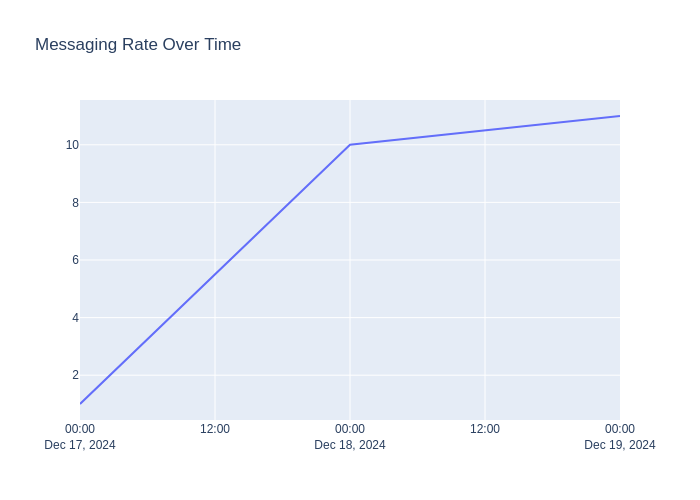

In [14]:
date_message_fig.show()

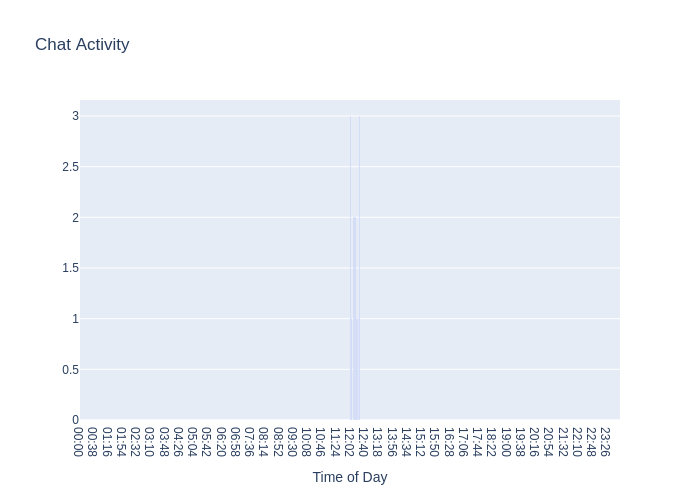

In [15]:
top_msg_hours_fig.show()

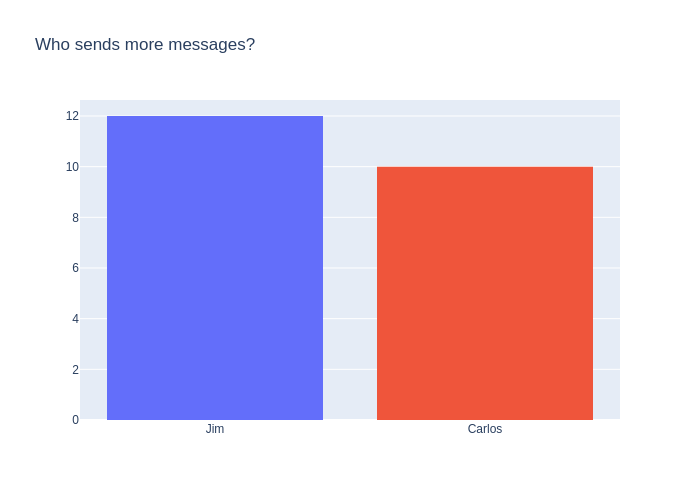

In [16]:
msg_sent_fig.show()

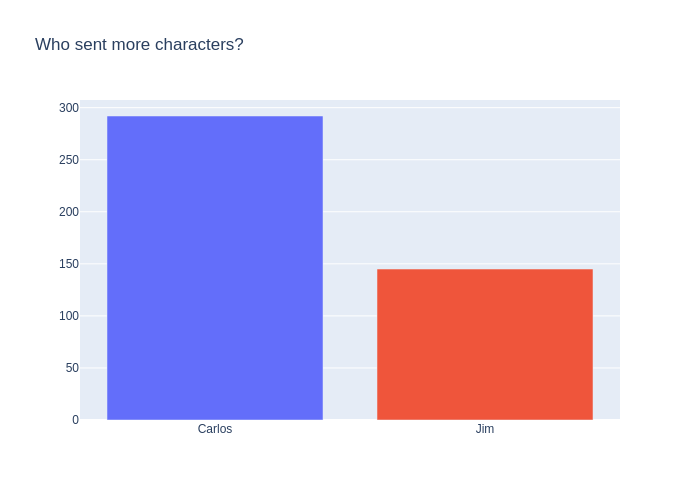

In [17]:
char_count_fig.show()

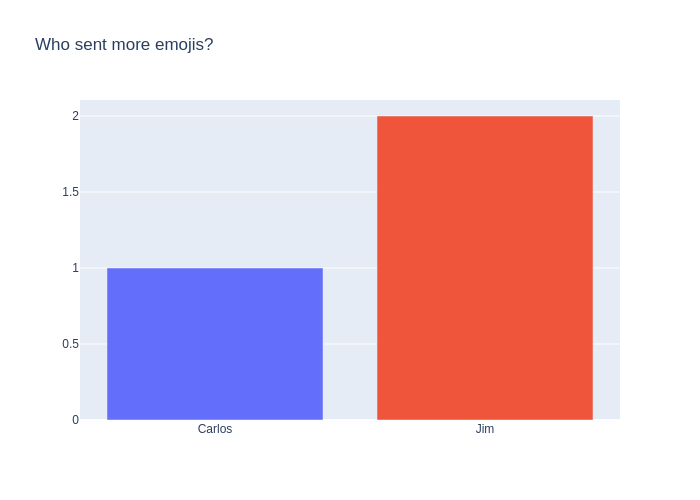

In [18]:
emoji_count_fig.show()

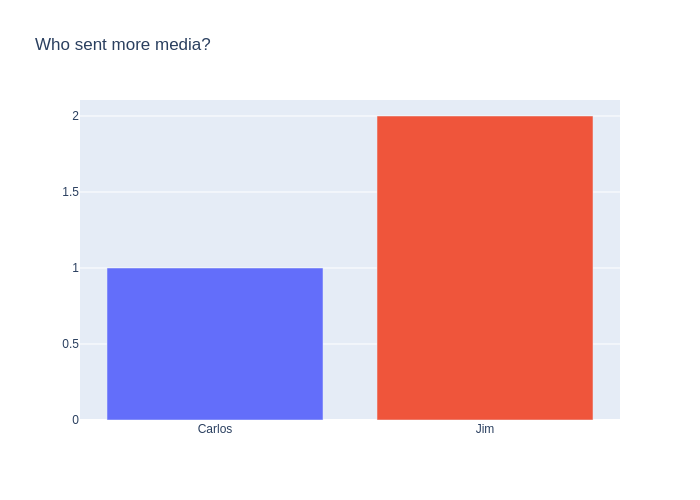

In [19]:
media_count_fig.show()

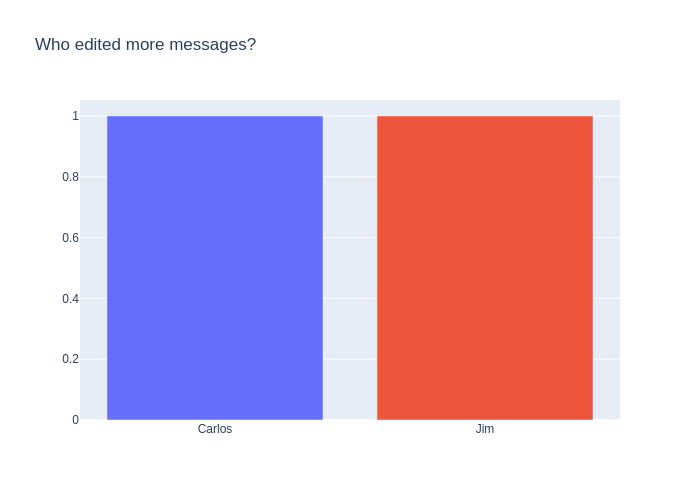

In [20]:
edited_count_fig.show()

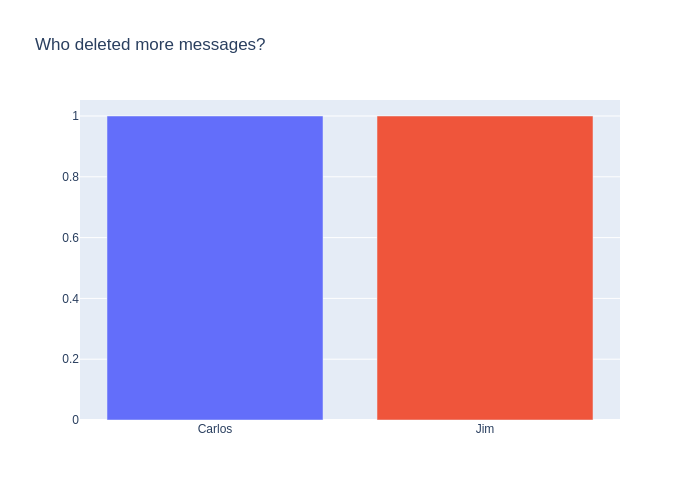

In [21]:
deleted_count_fig.show()